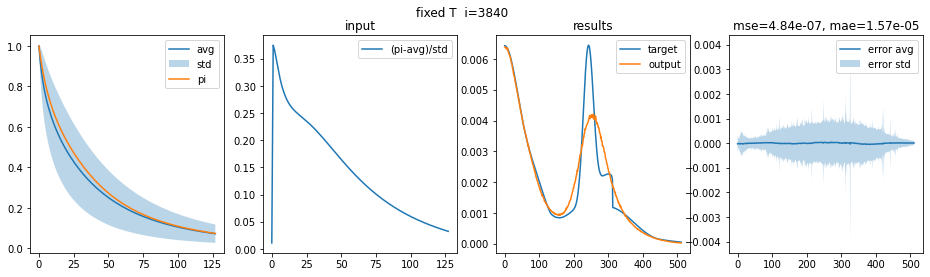

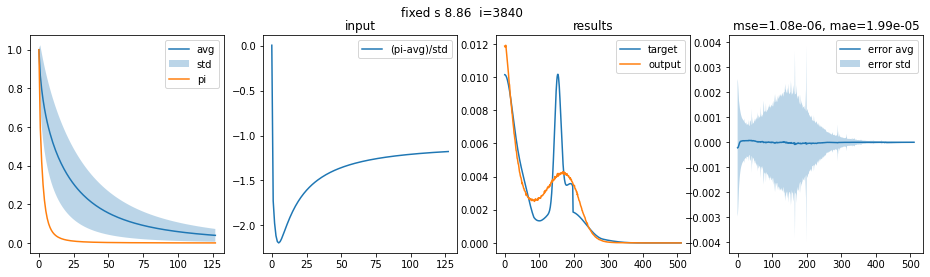

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from deep_continuation.training import MODELS_PATH, MLP
from deep_continuation.dataset import DATAPATH

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

sigma = {}
pi = {}
train_pi = {}
model_path = {}

sigma['fixed T=1/30']    = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20.npy"))
pi['fixed T=1/30']       = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta30.npy"))
train_pi['fixed T=1/30'] = np.load(os.path.join(DATAPATH, "default", "Pi_100000x1x1_seed55555_Nwn128_beta30.npy"))
model_path['fixed T=1/30'] = os.path.join(MODELS_PATH, "best_model_n0.0_10000x1x1_seed555_beta30_512x128_wmax20.pt")

sigma['fixed s=8.86']      = np.load(os.path.join(DATAPATH, "default", "sigma_10000x1x1_seed555_Nw512_wmax20_std8.86.npy"))
pi['fixed s=8.86']         = np.load(os.path.join(DATAPATH, "default", "Pi_10000x1x1_seed555_Nwn128_beta0to60_std8.86.npy"))
train_pi['fixed s=8.86']   = np.load(os.path.join(DATAPATH, "default", "Pi_100000x1x1_seed55555_Nwn128_beta0to60_std8.86.npy"))
model_path['fixed s=8.86'] = os.path.join(MODELS_PATH, "best_model_n0.0_10000x1x1_seed555_beta0to60_std8.86_512x128_wmax20.pt")

i = np.random.randint(0,10000)
for key in [ 'fixed T=1/30', 'fixed s=8.86']:

    avg = train_pi[key].mean(axis=-2)
    std = train_pi[key].std(axis=-2)
    pi_stdized = (pi[key] - avg)/std

    # Apply model
    model = MLP()
    model.load_state_dict(torch.load(model_path[key]))

    input = torch.tensor(pi_stdized).to(device).float()
    output = model(input).detach().numpy()

    error_avg = (output-sigma[key]).mean(axis=-2)
    error_std = (output-sigma[key]).std(axis=-2)

    mse = np.mean((output-sigma[key])**2)
    mae = np.mean(np.abs(error_avg))

    # Plot target 
    fig, ax = plt.subplots(1,4, figsize=(16,4))
    plt.suptitle(key+"  i="+str(i))
    x = np.arange(128)
    ax[0].plot(x, avg, label='avg')
    ax[0].fill_between(x, avg-std, avg+std, alpha=0.3, label='std')
    ax[0].plot(x, pi[key][i], label='pi')
    ax[0].legend()
    ax[1].set_title("input")
    ax[1].plot(pi_stdized[i], label='(pi-avg)/std')
    ax[1].legend()
    ax[2].set_title("results")
    ax[2].plot(sigma[key][i], label="target")
    ax[2].plot(output[i], label="output")
    ax[2].legend()

    x = np.arange(512)
    ax[3].set_title(f"mse={mse:.2e}, mae={mae:.2e}")
    ax[3].plot(x, error_avg, label="error avg")
    ax[3].fill_between(x, error_avg-error_std, error_avg+error_std, alpha=0.3, label='error std')
    ax[3].legend()
    plt.show()

